# Aims of this script:

Analyse existing water tables to understand potential sources of error and undertake an uncertainty analysis.

To value-add existing water table maps by understanding flow directions, magnitudes, recharge/discharge zones, and geologic structures.

What is the study area?

BoundingBox(left=138.92013888913038, bottom=-26.04598588667808, right=140.1162636646685, top=-24.849861111139962)

# Importing packages

In [136]:
import contextily
import fiona
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd
import rasterio 
from rasterio.features import rasterize
from rasterio import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from requests import Request
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
from owslib.wcs import WebCoverageService

%matplotlib notebook

# Check out what versions I am using

To find out GDAL version: use command prompt
GDAL 2.3.3, released 2018/12/14. Got this by typing into conda prompt: `gdalinfo --version`

In [2]:
print('python version: {}' .format(sys.version))
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pyproj version: {}'.format(pyproj.__version__))

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.4
pandas version: 1.3.4
matplotlib version: 3.5.0
pyproj version: 3.3.0


# Set up folder structures

In [4]:
os.chdir(r'C:\Users\mar886\WaterTableProject\aewt_project')
print("Current Directory", os.getcwd())

# Make folders for data and figures
if not os.path.exists("input_data"):
    os.makedirs("input_data")
       
if not os.path.exists("figures"):
    os.makedirs("figures")
    
if not os.path.exists("output_data"):
    os.makedirs("output_data")

Current Directory C:\Users\mar886\WaterTableProject\aewt_project


# Projection set ups

In [65]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32755')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

# Set up the bounding box

In [125]:
leftbbox = 138.92013888913038
bottombbox = -26.049861111151657
rightbbox = 140.1198611113643
topbbox = -24.849861111139962

# Set up the figure formatting

In [156]:
 wt_cmap = "viridis_r"
dem_cmap = "terrain"

plt_extent = [leftbbox, rightbbox, bottombbox, topbbox]

## Make a geodataframe of the bounding box to crop with.

Study extent as a polygon (`studyarea`) or geodataframe (`sa_gdf`).
Geodaframe is what seems to work best for cropping.

In [15]:
studyarea = shapely.geometry.box(leftbbox, bottombbox, rightbbox, topbbox) # minx, miny, maxx, maxy
print(type(studyarea))
print(studyarea)

print("Area of the study area is: %1.1f square degrees" % studyarea.area)
print("Length of the study area is: %1.1f square degrees" % studyarea.length)

sa_df = pd.DataFrame()
sa_df["geometry"] = [studyarea]
sa_gdf = gpd.GeoDataFrame(sa_df, geometry='geometry',crs=wgs84)
print(type(sa_gdf))

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((140.1198611113643 -26.049861111151657, 140.1198611113643 -24.849861111139962, 138.92013888913038 -24.849861111139962, 138.92013888913038 -26.049861111151657, 140.1198611113643 -26.049861111151657))
Area of the study area is: 1.4 square degrees
Length of the study area is: 4.8 square degrees
<class 'geopandas.geodataframe.GeoDataFrame'>


In [112]:
sa_bbox = rasterio.coords.BoundingBox(leftbbox, bottombbox, rightbbox, topbbox)

In [113]:
print(type(studyarea))
print(type(sa_bbox))

<class 'shapely.geometry.polygon.Polygon'>
<class 'rasterio.coords.BoundingBox'>


# Open the DEM data 

I am having trouble downloading it directly from the webserver for now.

In [44]:
dem_fname = "Hydro_Enforced_1_Second_DEM.tif"
dem_rstr_path = os.path.join("input_data", "Elvis_dl_15Nov21_geotiff", dem_fname)

with rio.open(dem_rstr_path) as grd:
    dem_ar = grd.read()[0,:,:]


In [50]:
dem_rstr = rasterio.open(dem_rstr_path)

print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print(dem_rstr.mode)
print(dem_rstr.closed)

DEM raster crs is: EPSG:4326
DEM raster shape: (4306, 4306)
DEM raster type: <class 'rasterio.io.DatasetReader'>
r
False


In [46]:
print(type(dem_rstr))

<class 'rasterio.io.DatasetReader'>


### Second, download the raster directly to be an array, with the metadata stored separately.

Instead of `dem_ar = grd.read()[0,:,:]` I could also use `dem_ar = grd.read(1)`, each band is indexed starting at 1 (not 0 like in Python).

In [49]:
with rio.open(dem_rstr_path) as grd:
    dem_ar = grd.read()[0,:,:]
    dem_meta = grd.profile   
    dem_bounds = grd.bounds
    dem_res = grd.res

### Plot the DEM raster

<IPython.core.display.Javascript object>


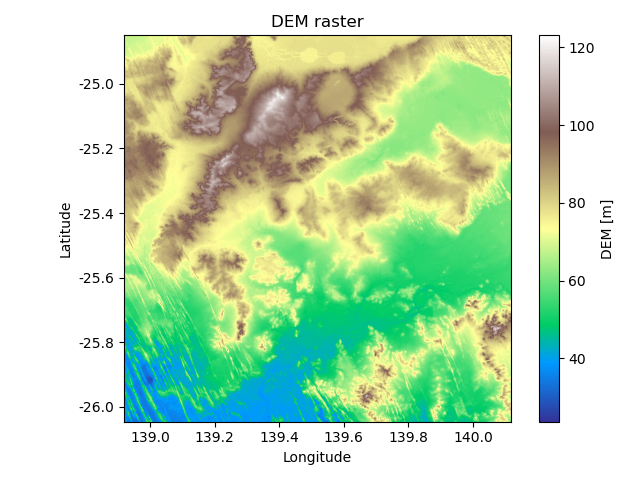

In [62]:
fig, (ax1) = plt.subplots(1, 1)

image_hidden = ax1.imshow(dem_ar, cmap=dem_cmap)

show(dem_rstr, ax=ax1, cmap=dem_cmap)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%2.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

ax1.set_title('DEM raster')

cbar = plt.colorbar(image_hidden)
cbar.set_label('DEM [m]')

plt.tight_layout()


# Water table contours data

These are saved as shapefiles.

In [63]:
wt_contour_fldr = os.path.join("input_data", "GAB_WT", "Watertable_Contour",
                               "wt_contour.shp")

wt_contour = gpd.read_file(wt_contour_fldr)

print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: PROJCS["GABWRA_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",143],PARAMETER["standard_parallel_1",-21],PARAMETER["standard_parallel_2",-29],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### Convert the coordinates of water table contour to be the same as the DEM

I should change it so that it is the other way around - DEM the same as the wt crs because Albers Equal Area Projection is a better choice.

In [68]:
wt_contour = wt_contour.to_crs(wgs84)
print("WT contour raster crs is: %s" % wt_contour.crs)

WT contour raster crs is: epsg:4326


### Plot the water table contours

Save the figure into the designated figures folder.

In [72]:
type(studyarea)

shapely.geometry.polygon.Polygon

<IPython.core.display.Javascript object>


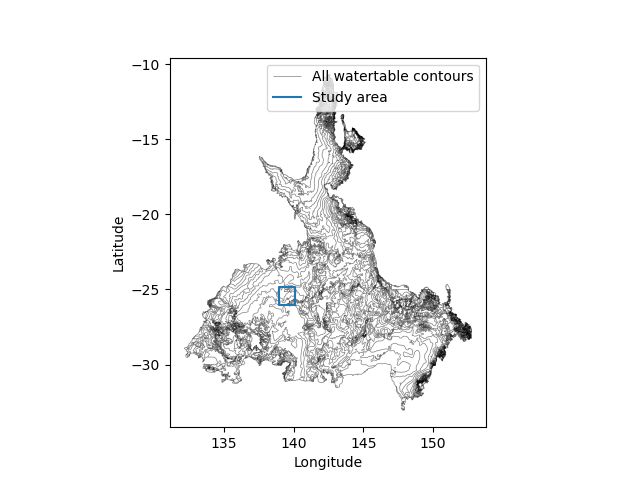

In [79]:
fig, ax = plt.subplots(1,1)
wt_contour.plot(ax=ax, color="k", alpha=0.5, linewidth=0.5, label="All watertable contours")

plt.plot(*studyarea.exterior.xy, label="Study area")

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend()

# Save figure
plt.savefig(os.path.join("figures", "original_contours"), dpi=300)

# Crop the water table contours to the study area

## 1. Get rid of all contours that aren't the water table contours (i.e. GAB boundary)

Need to check that the study area and the water table contours are in the same crs
Then make a copy of the dataframe so I can add the intersection geoseries over the top

In [84]:
wt_contour_filtr = wt_contour[wt_contour['height']>-9999]

if sa_gdf.crs == wt_contour_filtr.crs:
    print("Study area and water table contours are in the same crs")
else:
    print("Study area and water table contours are not in the same crs - conversion required")
    
contours_icpt_gdf = wt_contour_filtr.copy()

print(len(wt_contour))
print(len(contours_icpt_gdf))

Study area and water table contours are in the same crs
2832
1122


## 2. Crop contours based on the study area

In [85]:
contours_icpt_gdf['contours_icpt'] = wt_contour_filtr.intersection(sa_gdf.geometry[0])

## 3. Get only values where the geometry is not empty

In [87]:
is_empty_list = []
for i in range(len(contours_icpt_gdf)):
    is_empty_list.append(contours_icpt_gdf.iloc[i, 4].is_empty)
print(len(is_empty_list))

contours_icpt_gdf['is_empty'] = is_empty_list
contours_icpt_gdf_notempty = contours_icpt_gdf[contours_icpt_gdf['is_empty'] == False]

print(len(contours_icpt_gdf_notempty))

1122
5


### Plot the water table contours that intersect the study are and are not empty

<IPython.core.display.Javascript object>


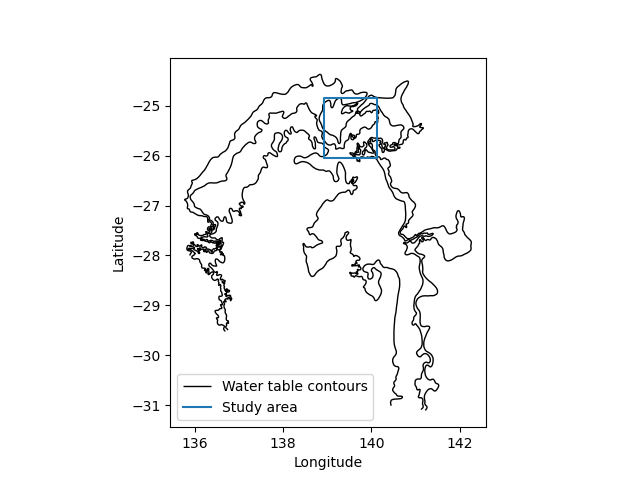

In [91]:
fig, ax = plt.subplots()
contours_icpt_gdf_notempty.plot(ax=ax, color="k", linewidth=1, label = "Water table contours")
plt.plot(*studyarea.exterior.xy, label="Study area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.legend()

### 4. Make a new gdf where the name geometry is changed

This is because the intercept column is actually the geometry.

Now it is a geopandas object and is the right shape, cropped to the study area.

In [92]:
contours_sa = contours_icpt_gdf_notempty.copy()
contours_sa = contours_sa.drop(labels="geometry", axis=1)

contours_sa = contours_sa.rename(columns={"contours_icpt":"geometry"})
print(len(contours_sa))


5


### Plot the water table contours cropped to the study area

<IPython.core.display.Javascript object>


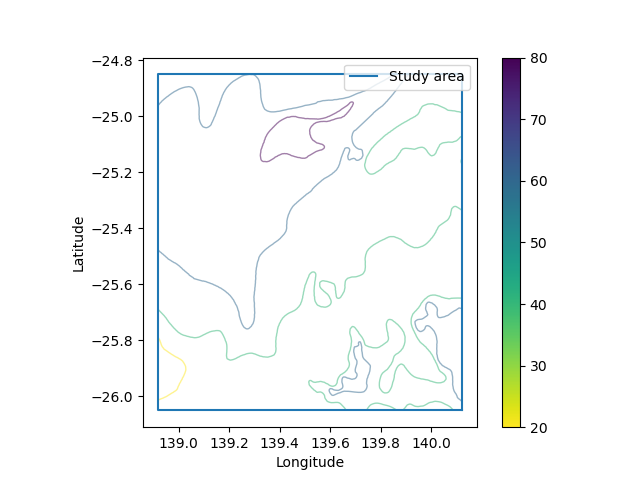

In [104]:
fig, ax = plt.subplots()
contours_sa.plot(ax=ax, column=contours_sa["height"], 
                 alpha=0.5, cmap=wt_cmap, linewidth=1, legend=True)
plt.plot(*studyarea.exterior.xy, label="Study area")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')

## Plot the DEM data with the water table contours 

Where the water table contours are shapefiles.

<IPython.core.display.Javascript object>


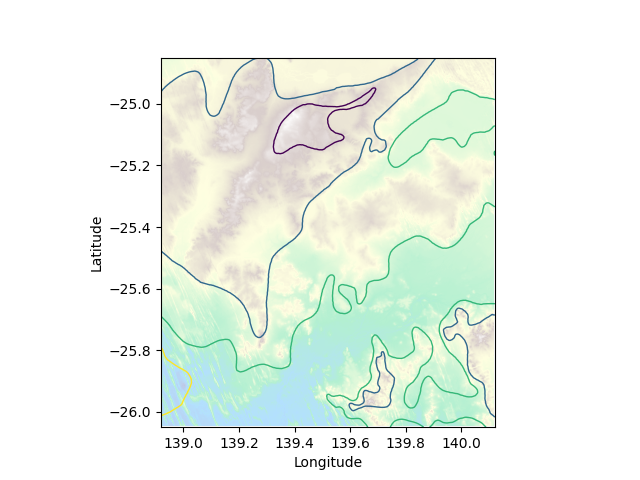

In [127]:
fig1, ax1 = plt.subplots()

show(dem_rstr, ax=ax1, cmap="terrain", alpha=0.3)

contours_sa.plot(ax=ax1, column=contours_sa["height"],
                 linewidth=1, cmap=wt_cmap)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax1.set_xlim([leftbbox, rightbbox])
ax1.set_ylim([bottombbox, topbbox])

plt.savefig(os.path.join("figures", "dem_with_contours"), dpi=300)

## Turn water table contours into a raster file

In [110]:
wt_rstr = rasterize(
    ((s, h) for s, h in zip(contours_sa['geometry'], contours_sa['height'])),
    out_shape=dem_ar.shape,
    transform=dem_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rasterio.int32)

print("Min value for wt raster: %2.2f" %wt_rstr.min())
print("Max value for wt raster: %2.2f" %wt_rstr.max())
print("Shape of wt raster: %s" %(wt_rstr.shape,))

Min value for wt raster: 0.00
Max value for wt raster: 80.00
Shape of wt raster: (4306, 4306)


### Plot the rasterised water level contours

<IPython.core.display.Javascript object>


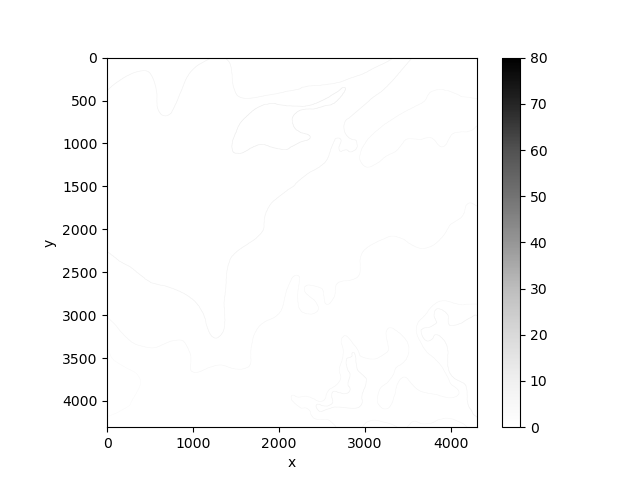

In [111]:
plt.figure()
plt.imshow(wt_rstr, cmap='Greys')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

plt.savefig(os.path.join("figures", "raster_contours"), dpi=300)

# River network data

### First step: download river data from Geofabric.

Here I am accessing the data directly from a webservice. The  url accesses BoM Geofabric Surface Hydrology Cartography.

In [122]:
WfsUrl = 'http://geofabric.bom.gov.au/simplefeatures/ahgf_shcarto/ows'
params = dict(service='WFS', 
              version='1.0.0', 
              request='GetFeature',
              typename='ahgf_shcarto:AHGFMappedStream', 
              bbox='%f,%f,%f,%f' % (sa_bbox[0],sa_bbox[1],sa_bbox[2],sa_bbox[3]),
              outputFormat='json')

q = Request('GET',WfsUrl,params=params).prepare().url
riv_wgs = gpd.read_file(q)
riv_wgs.crs # Already in wgs84
river_gdf = riv_wgs.to_crs(wgs84)

### Plot the river network

<IPython.core.display.Javascript object>


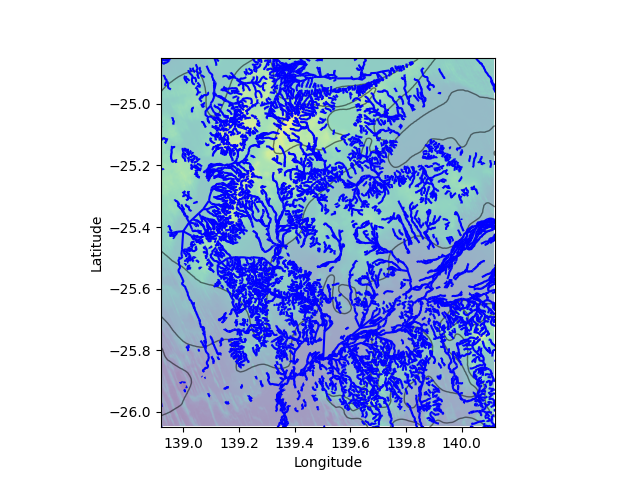

In [126]:
fig1, ax1 = plt.subplots()
show(dem_rstr, ax=ax1, alpha=0.5)
contours_sa.plot(ax=ax1, color="k", alpha=0.5, linewidth=1)
river_gdf.plot(ax=ax1, edgecolor='b')

plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax1.set_xlim([leftbbox, rightbbox])
ax1.set_ylim([bottombbox, topbbox])

plt.savefig(os.path.join("figures", "dem_riv_contours"), dpi=300)

## Rasterise the river network

Here, I am only selecting the "major" rivers, but I can change this and use all of them or select via a different attribute.

First I will check out what are the columns of the river data - i.e. what features have been defined?

In [128]:
print(river_gdf.columns)
print(river_gdf['hierarchy'].unique())

Index(['id', 'hydroid', 'ahgfftype', 'name', 'hierarchy', 'perennial',
       'aushydroid', 'from_node', 'to_node', 'nextdownid', 'enabled',
       'flowdir', 'srcfcname', 'srcftype', 'srctype', 'sourceid', 'featrel',
       'fsource', 'attrrel', 'attrsource', 'planacc', 'symbol', 'textnote',
       'geodeslen', 'upstrgeoln', 'shape_length', 'geometry'],
      dtype='object')
['Major' 'Minor']


In [129]:
river_index = river_gdf.hierarchy=='Major'

## Now create the raster of major rivers

What feature am I going to use as the value? Previous work by Luk used 'hydroid', what is this?

In [130]:
print(river_gdf['hydroid'].unique())

[5468205 5469611 5470597 ... 6597895 6599397 6599398]


In [132]:
raster_rivers = rasterize(
    ((s, v) for s, v in zip(river_gdf[river_index].geometry, 
                            river_gdf[river_index].hydroid)),
    out_shape=dem_ar.shape,
    transform=dem_meta['transform'],
    fill = 0,
    all_touched = True,
    default_value = 0,
    dtype=rio.int32)

print("Min value for rivers raster: %2.2f" %raster_rivers.min())
print("Max value for rivers raster: %2.2f" %raster_rivers.max())
print("Shape of rivers raster: %s" %(raster_rivers.shape,))

Min value for rivers raster: 0.00
Max value for rivers raster: 6060551.00
Shape of rivers raster: (4306, 4306)


### Alter the raster so that at each river location the value is 1 (not the value of the hydroid) 

**I'm sure I can get rid of this step using a slightly different approach to my rasterisation**

In [133]:
raster_rivers[raster_rivers > 0] = 1

### Plot the rasterised river network

<IPython.core.display.Javascript object>


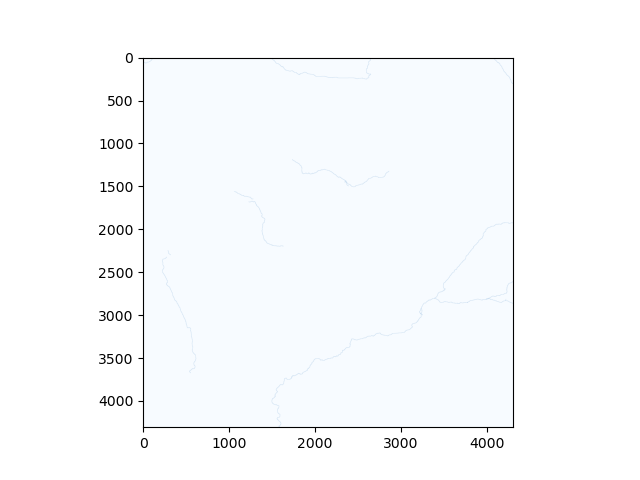

In [144]:
plt.figure()
plt.imshow(raster_rivers, cmap="Blues",interpolation=None)
plt.savefig(os.path.join("figures", "riv_raster"), dpi=300)

# Water table elevation raster data

Geoscience Australia also made a raster file of water table elevation (interpolated the contours using TopoToRaster tool in ArcGIS and saved it as ASCII Grid file. This file is not accompanied by a .prj file - i.e. it does not have projection information.

To overcome issues with no projection, my only work-around (for now) was to open the file in ArcGIS and convert it to a Tiff and asign it a projection, I could not figure out how to do this using Python tools.

I am calling this the `wt_rstr_real`, i.e. calling it *real* because it is one that was prepared by a third party, ideally is geologically correct and I can compare it to any interpolation that I do myself.

Note that the cell size is completely different - it is 1000m for this file compared to 30m for the DEM.

In [147]:
wt_rstr_real_file = os.path.join("input_data", "GAB_WT", 
                           "Watertable_Elev", "ASCII_Grid",
                          'wt1.tif')

wt_rstr_real = rio.open(wt_rstr_real_file,
                         driverstr="GTiff")

print(type(wt_rstr_real))

<class 'rasterio.io.DatasetReader'>


## Download the wt real raster directly as an array

With meta-data stored separately

In [153]:
with rio.open(wt_rstr_real_file) as wtgrd:
    wt_real_ar = wtgrd.read()[0,:,:]
    wtgrid_meta = wtgrd.profile   
    wtbounds = wtgrd.bounds
    wtres = wtgrd.res

In [162]:
wt_real_extent = [wtbounds[0], wtbounds[2], wtbounds[1], wtbounds[3]]
print(wt_real_extent)

[131.7929065313367, 153.19464321761788, -33.137046551593485, -10.341478515305077]


### Filter WT Real array to remove the very low values (nan values) and change them to np.nan

In [154]:
wt_real_ar_f = np.where(wt_real_ar < 0, np.nan, wt_ar)

### Plot what the real water table raster looks like

<IPython.core.display.Javascript object>


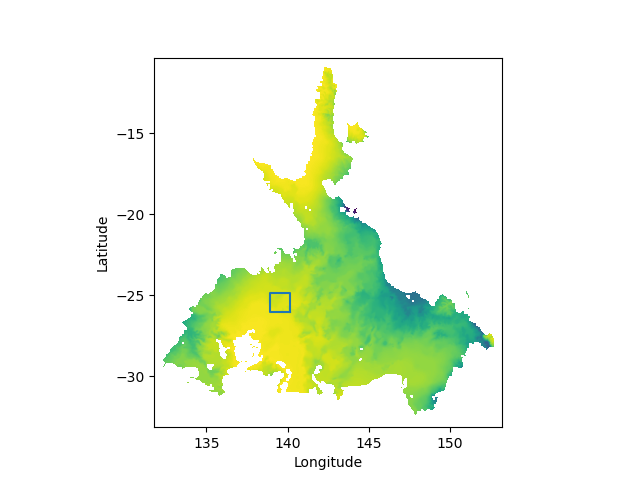

In [163]:
fig1, ax1 = plt.subplots()
img = ax1.imshow(wt_real_ar_f, cmap=wt_cmap, extent=wt_real_extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(*studyarea.exterior.xy, label="Study area")